In [103]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
import pandas as pd
import numpy as np
from IPython.display import clear_output

filename = lambda x:"/Users/rainy21/IPL1/single-photon-interference/LASER/B-1/B-1_DoubleSlit_14-2.csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(V)"
MILIVOLTE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLTE_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLTE_COL] / 1000
  data = data
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  volt = np.array(volt)
  volt = volt / max(volt)
  return pos, volt

def plot_data(x, volt=None):
  pos, origninal_volt = get_data(x)
  volt = origninal_volt
  volt = np.array(volt)
  volt = volt / max(volt)
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)})")

device = th.device('cpu')
GAP_DOUBLE_SLIT = {
  14: 356e-6,
  15: 406e-6,
  15: 457e-6,
}

In [111]:
I0 = th.tensor(1, dtype=th.float64, device=device, requires_grad=False)
lamb = 650e-9
k = th.tensor(2 * th.pi / lamb, dtype=th.float64, device=device, requires_grad=True)
h = th.tensor(GAP_DOUBLE_SLIT[14], dtype=th.float64, device=device, requires_grad=True)
b = th.tensor(85e-6, dtype=th.float64, device=device, requires_grad=True)
L = th.tensor(0.489, dtype=th.float64, device=device, requires_grad=True)
transform = th.tensor(5e-3, dtype=th.float64, device=device, requires_grad=True)
x = th.linspace(1e-3, 8.9999e-3, 161)
theta = ((x-transform) / L)
beta = 1/2 * k * b * th.sin(theta)
gamma = 1/2 * k * h * th.sin(theta)
eps=0
I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))

loss: 0.1540332514108732
transform: 0.005403212505079741
lambda: 650.0000000004422 nm


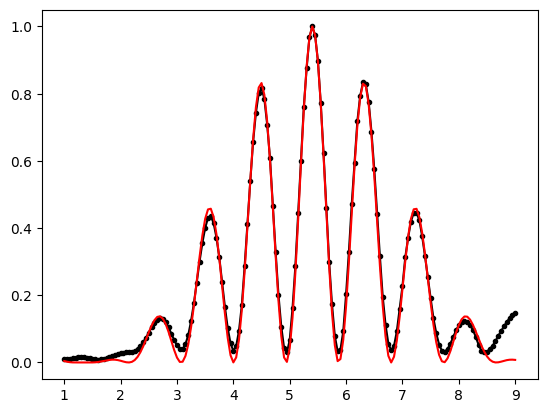

R2: 0.9858994500502997


In [112]:
optimizer = th.optim.Adam([transform, k, L, h, b], lr=1e-7)
pos, volt = get_data(14)
volt_tensor = th.tensor(volt, dtype=th.float64, device=device)
for i in range(10000):
  optimizer.zero_grad()
  theta = ((x-transform) / L)
  beta = 1/2 * k * b * th.sin(theta)
  gamma = 1/2 * k * h * th.sin(theta)
  I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))
  loss = th.sum(th.square(I - volt_tensor))
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    clear_output(wait=True)
    print(f"loss: {float(loss)}")
    print(f"transform: {float(transform)}")
    print(f"lambda: {2 * th.pi / float(k) * 1e9} nm")
    plt.plot(pos, volt_tensor, color='black', marker='o', mfc='black', mec='black', ms=3)
    plt.plot(x * 1e3, I.detach().numpy(), color='red')
    plt.show()

R2 = 1 - th.sum(th.square(volt_tensor - I)) / th.sum(th.square(volt_tensor - th.mean(volt_tensor)))
print(f"R2: {float(R2)}")

# Integral

In [ ]:
I0 = th.tensor(1, dtype=th.float64, device=device, requires_grad=False)
lamb = 650e-9
k = th.tensor(2 * th.pi / lamb, dtype=th.float64, device=device, requires_grad=True)
h = th.tensor(GAP_DOUBLE_SLIT[14], dtype=th.float64, device=device, requires_grad=True)
b = th.tensor(85e-6, dtype=th.float64, device=device, requires_grad=True)
L = th.tensor(0.489, dtype=th.float64, device=device, requires_grad=True)
transform = th.tensor(5e-3, dtype=th.float64, device=device, requires_grad=True)
x = th.linspace(1e-3, 8.9999e-3, 161)
theta = ((x-transform) / L)
beta = 1/2 * k * b * th.sin(theta)
gamma = 1/2 * k * h * th.sin(theta)
I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))

In [ ]:
optimizer = th.optim.Adam([transform, k, L, h, b], lr=1e-7)
pos, volt = get_data(14)
volt_tensor = th.tensor(volt, dtype=th.float64, device=device)
for i in range(10000):
  optimizer.zero_grad()
  theta = ((x-transform) / L)
  beta = 1/2 * k * b * th.sin(theta)
  gamma = 1/2 * k * h * th.sin(theta)
  I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))
  loss = th.sum(th.square(I - volt_tensor))
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    clear_output(wait=True)
    print(f"loss: {float(loss)}")
    print(f"transform: {float(transform)}")
    print(f"lambda: {2 * th.pi / float(k) * 1e9} nm")
    plt.plot(pos, volt_tensor, color='black', marker='o', mfc='black', mec='black', ms=3)
    plt.plot(x * 1e3, I.detach().numpy(), color='red')
    plt.show()

R2 = 1 - th.sum(th.square(volt_tensor - I)) / th.sum(th.square(volt_tensor - th.mean(volt_tensor)))
print(f"R2: {float(R2)}")

In [127]:
I0 = I0
h = h
lamb0 = 2 * th.pi / k
z = th.linspace(-0.2, 0.2, 41)
alpha = th.tensor(1, dtype=th.float64, device=device, requires_grad=True)
k = k * (1 + z)
p = 1 / (1 + th.square(z / alpha))
b = b
L = L
transform = transform
x = th.linspace(1e-3, 8.9999e-3, 161)
theta = ((x-transform) / L)
beta = 1/2 * k[:, None] * b * th.sin(theta)[None, :]
gamma = 1/2 * k[:, None] * h * th.sin(theta)[None, :]
I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))
I = th.sum(I * p[:, None], axis=0) / th.sum(p)

loss: 0.11850183624774338
alpha: 0.0029516514147274295


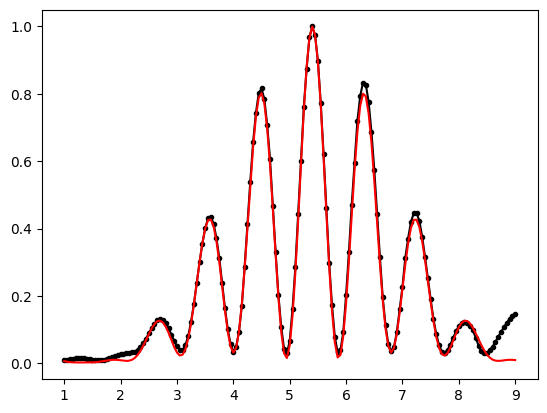

R2: 0.9891520706602758


In [137]:
optimizer = th.optim.Adam([alpha], lr=1e-6)
pos, volt = get_data(14)
volt_tensor = th.tensor(volt, dtype=th.float64, device=device)
I1 = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))
I1 = I1.detach()
for i in range(10000):
  optimizer.zero_grad()
  p = 1 / (1 + th.square(z / alpha))
  I = th.sum(I1 * p[:, None], axis=0) / th.sum(p)
  loss = th.sum(th.square(I - volt_tensor))
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    clear_output(wait=True)
    print(f"loss: {float(loss)}")
    print(f"alpha: {float(alpha)}")
    plt.plot(pos, volt_tensor, color='black', marker='o', mfc='black', mec='black', ms=3)
    plt.plot(x * 1e3, I.detach().numpy(), color='red')
    plt.show()
R2 = 1 - th.sum(th.square(volt_tensor - I)) / th.sum(th.square(volt_tensor - th.mean(volt_tensor)))
print(f"R2: {float(R2)}")